# 第六题：实现高斯混合聚类，并与其他聚类算法进行对比（必做）

实验内容：
1. 实现高斯混合聚类
2. 至少选择两个数据集
3. 在这两个数据集上运行自己实现的层次聚类算法和sklearn的KMeans，层次聚类，DBSCAN，共4个聚类算法
4. 计算外部指标FMI和NMI
5. 绘制4种聚类的聚类效果

截止时间延长到11月11日。

## 1. 数据集1

聚类算法|FMI|NMI
-|-|-
myGMM|0.49996285815 | 0.000251988254241
kmeans|0.499508771535 | 0.000128304193592
层次|1.0|1.0
DSCAN|0.999333110963 | 0.996355857029

## 2. 数据集2

聚类算法|FMI|NMI
-|-|-
myGMM|0.689318176224 | 0.294378961164
kmeans|0.624526404259 | 0.188766312522
层次|1.0|1.0
DSCAN|0.998667559119 | 0.993404812241

## 模块导入

In [1]:
# YOUR CODE HERE
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
from sklearn.cluster import KMeans
from collections import defaultdict
import math
import copy

## 数据集生成

In [3]:
from sklearn import datasets
X1, y1 = datasets.make_circles(n_samples = 1500, factor = 0.5, noise = 0.05, random_state = 32)
X2, y2 = datasets.make_moons(n_samples = 1500, noise = 0.05, random_state = 32)

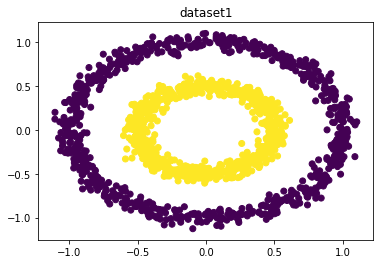

In [4]:
plt.title('dataset1')
plt.scatter(X1[:, 0], X1[:, 1],c = y1)

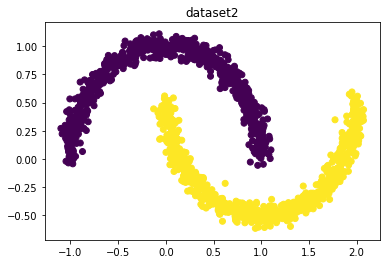

In [5]:
plt.title('dataset2')
plt.scatter(X2[:, 0], X2[:, 1], c =y2)

In [6]:
# 高斯分布的概率密度函数
def prob(x, mu, sigma):
    
    # np.linalg.det 计算矩阵的行列式
    n = x.shape[0]
    expOn = float(-0.5 * ((x - mu) * (sigma.I)).dot((x - mu).T))
    divBy = pow(2 * np.pi, n / 2) * pow(np.linalg.det(sigma), 0.5)
    return pow(np.e, expOn) / divBy

In [7]:
class GMM:
    def __init__(self, maxstep=1000, epsilon=1e-3, K=4):
        self.maxstep = maxstep #最大迭代次数
        self.epsilon = epsilon
        self.K = K  # 混合模型中的分模型的个数(即最后要划分为几个类)

        self.alpha = None  # 每个分模型前系数
        self.mu = None  # 每个分模型的均值向量
        self.sigma = None  # 每个分模型的协方差
        self.gamma_all_final = None  # 存储最终的每个样本对分模型的响应度，用于最终的聚类

        self.D = None  # 输入数据的维度
        self.N = None  # 输入数据个数

    def inin_param(self, data):
        # 初始化参数
        self.D = data.shape[1]  
        self.N = data.shape[0]

        # KMeans初始化模型参数
        KMEANS = KMeans(n_clusters=self.K).fit(data)
        clusters = defaultdict(list)
        for ind, label in enumerate(KMEANS.labels_):
            clusters[label].append(ind)
        mu = []
        alpha = []
        sigma = []
        for inds in clusters.values():
            partial_data = data[inds]
            mu.append(partial_data.mean(axis=0))  # 分模型的均值向量
            alpha.append(len(inds) / self.N)  # 权重
            sigma.append(np.cov(partial_data.T))  # 协方差,D个维度间的协方差
        self.mu = np.array(mu)
        self.alpha = np.array(alpha)
        self.sigma = np.array(sigma)
        return

    def _phi(self, y, mu, sigma):
        # 获取分模型的概率
        s1 = 1.0 / math.sqrt(np.linalg.det(sigma)) #求矩阵行列式
        s2 = np.linalg.inv(sigma)  # d*d #求矩阵的逆
        delta = np.array([y - mu])  # 1*d
        return s1 * np.exp(-1.0 / 2 * np.matmul(np.matmul(delta, s2), delta.T))      

    def fit(self, data):
        # 迭代训练
        self.inin_param(data)
        step = 0
        gamma_all_arr = None
        while step < self.maxstep:
            step += 1
            old_alpha = copy.copy(self.alpha)
            
            # E步骤
            gamma_all = []
            for j in range(self.N):
                gamma_j = []    # 依次求每个样本对K个分模型的响应度

                for k in range(self.K):
                    gamma_j.append(self.alpha[k] * self._phi(data[j], self.mu[k], self.sigma[k]))

                s = sum(gamma_j)
                gamma_j = [item / s for item in gamma_j]
                gamma_all.append(gamma_j)

            gamma_all_arr = np.array(gamma_all)
            
            # M步骤
            for k in range(self.K):
                gamma_k = gamma_all_arr[:, k]
                SUM = np.sum(gamma_k)
                # 更新权重
                self.alpha[k] = SUM / self.N  # 更新权重
                # 更新均值向量
                new_mu = sum([(gamma * y) for (gamma, y) in zip(gamma_k, data)]) / SUM  
                self.mu[k] = new_mu
                # 更新协方差阵
                delta_ = data - new_mu   # n*d
                self.sigma[k] = sum([gamma * (np.outer(np.transpose([delta]), delta)) for (gamma, delta) in zip(gamma_k, delta_)]) / SUM 
            alpha_delta = self.alpha - old_alpha
            if np.linalg.norm(alpha_delta, 1) < self.epsilon:
                break
        self.gamma_all_final = gamma_all_arr
        return

    def predict(self):
        cluster = np.arange(self.N).reshape(self.N, )
        for j in range(self.N):
            max_ind = np.argmax(self.gamma_all_final[j])
            cluster[j] = max_ind
        return cluster


In [8]:
from sklearn.metrics import normalized_mutual_info_score
from sklearn.metrics import fowlkes_mallows_score

## 数据集1

0.000251988254241
0.49996285815


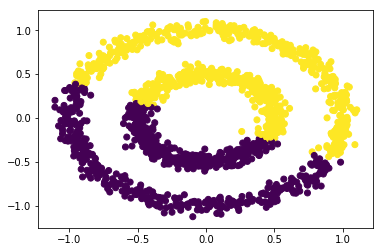

In [9]:
#myGMM
model = GMM(K=2)
model.fit(X1)
my_pred = model.predict()
plt.scatter(X1[:, 0], X1[:, 1], c = my_pred)
print(normalized_mutual_info_score(y1, my_pred))
print(fowlkes_mallows_score(y1, my_pred))

0.000128304193592
0.499508771535


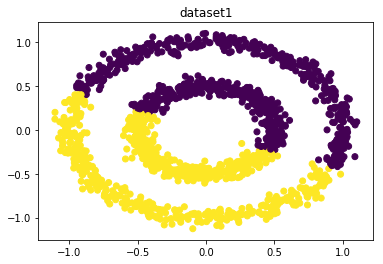

In [10]:
#KMeans
from sklearn.cluster import KMeans

model = KMeans(n_clusters=2)
model.fit(X1)
plt.title('dataset1')
plt.scatter(X1[:, 0], X1[:, 1],c=model.predict(X1))
print(normalized_mutual_info_score(y1, model.predict(X1)))
print(fowlkes_mallows_score(y1, model.predict(X1)))

1.0
1.0


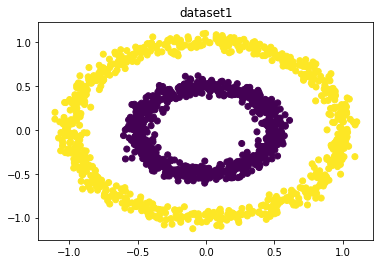

In [17]:
#层次聚类
from sklearn.cluster import AgglomerativeClustering
model = AgglomerativeClustering(n_clusters = 2, linkage="single")
model.fit(X1)
pred = model.labels_
plt.title('dataset1')
plt.scatter(X1[:, 0], X1[:, 1], c=pred)
print(normalized_mutual_info_score(y1, pred))
print(fowlkes_mallows_score(y1, pred))

0.996355857029
0.999333110963


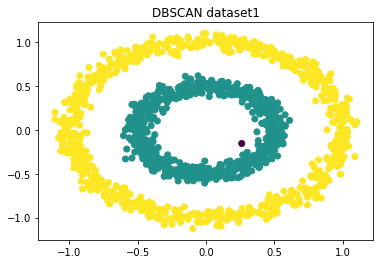

In [12]:
#DBSCAN
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps = 0.1)
dbscan.fit(X1)

plt.title('DBSCAN dataset1')
plt.scatter(X1[:, 0], X1[:, 1], c = dbscan.labels_)

print(normalized_mutual_info_score(y1, dbscan.labels_))
print(fowlkes_mallows_score(y1, dbscan.labels_))

## 数据集2

0.294378961164
0.689318176224


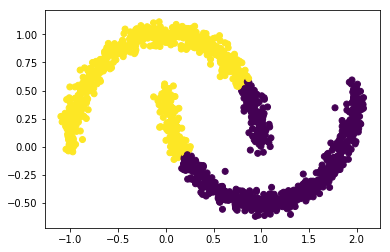

In [13]:
#myGMM
model = GMM(K=2)
model.fit(X2)
my_pred = model.predict()
plt.scatter(X2[:, 0], X2[:, 1], c = my_pred)
print(normalized_mutual_info_score(y2, my_pred))
print(fowlkes_mallows_score(y2, my_pred))

0.188766312522
0.624526404259


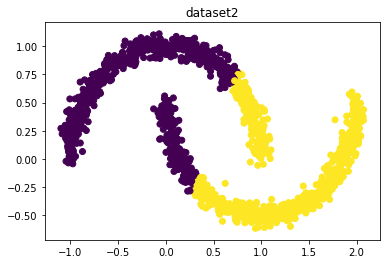

In [14]:
#KMeans
from sklearn.cluster import KMeans

model = KMeans(n_clusters=2)
model.fit(X2)
plt.title('dataset2')
plt.scatter(X2[:, 0], X2[:, 1], c=model.predict(X2))
print(normalized_mutual_info_score(y2, model.predict(X2)))
print(fowlkes_mallows_score(y2, model.predict(X2)))

NMI: 1.0
FMI: 1.0


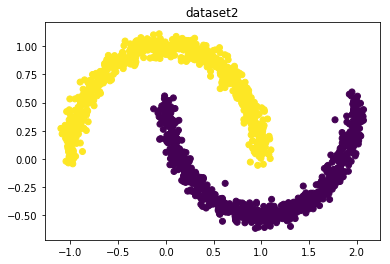

In [15]:
#层次聚类
from sklearn.cluster import AgglomerativeClustering
model = AgglomerativeClustering(n_clusters = 2, linkage="single")
model.fit(X2)
pred = model.labels_
plt.title('dataset2')
plt.scatter(X2[:, 0], X2[:, 1], c= pred)
print("NMI:", normalized_mutual_info_score(y2, pred))
print("FMI:", fowlkes_mallows_score(y2, pred))

0.993404812241
0.998667559119


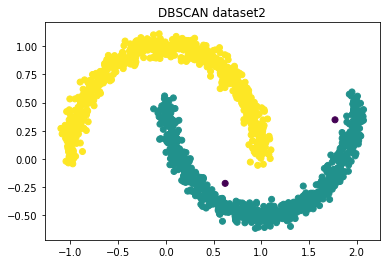

In [16]:
#DBSCAN
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps = 0.1)
dbscan.fit(X2)

plt.title('DBSCAN dataset2')
plt.scatter(X2[:, 0], X2[:, 1], c = dbscan.labels_)

print(normalized_mutual_info_score(y2, dbscan.labels_))
print(fowlkes_mallows_score(y2, dbscan.labels_))